<h1>Project summary</h1>

This analysis consist of research of almost 900 people that have been aboard the Titanic ship. The project includes <b>engineering of multiple features</b> (e.g. group size, total ticket fare) and <b>various missing values handling methods</b>, brief exploratory data analysis and then focuses on <b>predictions, feature selection and hyperparameter tuning</b>.



The task was to predict the <b>sex of each passenger</b> using known features such as class or fare. For obvious reasons, use of passenger's names was prohibited.  We implemented a <b>Random forest</b> model and a <b>Neural network with an embedding layer</b>, both of the models reaching <b>area under ROC curve of around 0.86</b> with the neural network being slightly higher and with much more room for improvement if necessary (feature selection).

<h1>Project outline</h1>

    - State the initial hypotheses and assumptions
    - Make necessary imports, take first look at the dataset
    - Clean the dataset, deal with the missing values, engineer new features
    - Explore the relationships between sex and other variables
    - Prepare the dataset for the predictive part
    - Build the Random forest model
        - Tune the hyperparameters
        - Perform feature selection
    - Build the Neural network
        - Build the structure, create embedding layer
        - Tune the hyperparameters
        - Assess overfitting
    - Compare the models, evaluate 

<h1>Initial hypotheses</h1>

    - Sex of the passengers will be strongly correlated to survival rate since women ought to be saved first
    - Taking into account the conditions at that time, women will be:
        - Less likely to travel in non-family groups
        - More likely to travel with bigger families
        - Very non-likely to travel alone
    - There will be decks that will have higher percentages of women
    - The 3rd class will have significantly more men as there will be workers included
    - The embarkation location will not be anyhow meaningful in terms of predicting the Sex of the passenger

<h1>Necessary imports, first look at the dataset</h1>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score

import tensorflow
import keras
from tensorflow.keras import layers
from keras import models
from keras.layers import Embedding, Dense, Flatten, Dropout, Input, Concatenate

In [2]:
pd.set_option("max_columns", 20)
sb.set_palette("deep")

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df["Sex"].unique()

array(['male', 'female'], dtype=object)

<h1>Variable identification, Missing values, Assumptions</h1>

In [8]:
# Target variable - "Sex" - categorical variable consisting of "male" and "female" entries
# Data types - numeric and text
# Variable category
    # Categorical:
        # Survived, Pclass, Ticket, Cabin, Embarked, Sex
    # Continuous:
        # Age, SibSp, Parch, Fare

In [9]:
# Missing values:
    # Age - 177
    # Cabin - 687
    # Embarked - 2

In [10]:
# Key assumptions:

    # Passenger ID is not a relevant attribute and might lead to overfit and/or confusion of the model
    
    # Keeping the Name column would lead to extreme overfit and/or in-sample scoring in terms of the target Sex attribute
        # This goes for any other attributes that might be derived from the Name feature (e.g. Title, Married etc.)
            # One exception: There are 2 missing values in Embarked that we will fill using the Name attribute
    
    # There are no errors in the data
        # This is a very dataset-specific assumption
            
df.drop("PassengerId", inplace=True, axis=1)

# Other assumptions:

    # Save women and children first implications:
        # Age and Survived will be strongly correlated
        # Sex and Survived will be strongly correlated

<h2>Feature engineering</h2>

In [11]:
# Now, we will add four new features to bring in more information and interpretability:
    # Group size
        # The number of people that boarded using the same ticket
    # Total Fare
        # The Fare value multiplied by the Group size
    # Family size
        # We will find this number as:
            # SibSp (number of siblings and spouses aboard) + Parch (num. of parents/children aboard) + 1
    # Travelled alone
        # Quite self-telling
    # Deck 
        # Since the majority of the Cabin column is missing, it might be very beneficial for the model
        # to be less specific about the exact Cabin number (it is probably irrelevant) and only use the Deck attribute

ticket_agg = df.groupby("Ticket").agg("count")
df["GroupSize"] = df["Ticket"].apply(lambda x: ticket_agg.loc[x][0])
df["TotalFare"] = df["Fare"]*df["GroupSize"]
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["Alone"] = (df["FamilySize"] + df["GroupSize"]).apply(lambda x: 1 if x == 2 else 0)
df["Deck"] = df["Cabin"].str.extract(r"([A-Z])")

# Move the Sex column to the end since it will be our target variable and make a small cosmetic upgrade
df["Sex"] = df.pop("Sex").apply(lambda x: x.capitalize())

# Validate that it is possible to fill in the Deck attribute using the approach above:
df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

<h2>Dealing with the missing values</h2>

<h3>Embarked</h3>

In [12]:
# Since there are only 2 missing values in Embarked, we might be able to fill it in manually
df[df["Embarked"].isna()]

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupSize,TotalFare,FamilySize,Alone,Deck,Sex
61,1,1,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,2,160.0,1,0,B,Female
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,2,160.0,1,0,B,Female


In [13]:
# This is the only place where we will allow ourselves to use the Name attribute
# Based on the Names of the 2 ladies (that have Embarked together - same ticket) we can conclude that they
# embarked at Southampton -> we will fill these values with "S"
    # Source: https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html

# Now we can (or rather have to) drop the Name column

df.loc[df["Name"] == "Icard, Miss. Amelie", "Embarked"] = "S"
df.loc[df["Name"] == "Stone, Mrs. George Nelson (Martha Evelyn)", "Embarked"] = "S"
df.drop(columns=["Name"], inplace=True)

<h3>Deck</h3>

In [14]:
# The deck feature is, by nature, a very important one 
# and despite the large number of missing values, it would be unwise to simply drop it

# To fill the missing values in the Deck attribute, we will work under multiple assumptions:
    # 1. Cabin number itself is not as important as the Deck specified by the letter preceeding the Cabin number
        # The cabin number itself might confuse the module and lead to overfit
    # 2. Passengers with the same ticket will be located on the same Deck (for validation see the code below)
        # 2.a) Apart from this, the ticket number will not be relevant enough and might confuse the model
    # 3. The decks will be correlated with the passenger's class and fare and especially with the survival rate

In [15]:
# Create a function to check, whether there are same deck values within the same tickets
def check_duplicates(entry):
    set_entry = set(entry)
    if len(set_entry) != 1 and np.nan not in set_entry:
        return True
    else:
        return False

# Show only rows with the same ticket but different deck
sub_df = df.groupby("Ticket")["Deck"].agg(list).apply(check_duplicates)
lst = list(sub_df[sub_df == True].index)
df[df["Ticket"].isin(lst)].sort_values("Ticket")

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupSize,TotalFare,FamilySize,Alone,Deck,Sex
110,0,1,47.0,0,0,110465,52.0000,C110,S,2,104.0000,1,0,C,Male
475,0,1,NaN,0,0,110465,52.0000,A14,S,2,104.0000,1,0,A,Male
309,1,1,30.0,0,0,PC 17485,56.9292,E36,C,2,113.8584,1,0,E,Female
599,1,1,49.0,1,0,PC 17485,56.9292,A20,C,2,113.8584,2,0,A,Male


In [16]:
# The conclusion is, that there are 2 pairs with the same ticket but different deck
# On the other hand, the total number of groups with a "group ticket" is 134 of which
# 48 are with at least two known decks (to validate the assumption)

# This means that 2 out of 48 similar groups differ in their deck, which is less than 5 %
    # This result does not take into account that there are bigger groups than pairs
    # Taking that into account, the 2 pairs would be even less relevant

# Therefore, the second assumption is completely valid and we can expect people
# with the same ticket to board the same cabin

In [17]:
# Based on the validated second assumption, we can fill in Deck feature of people
# that boarded within the same ticket based on the deck of somebody else in the group

# Sidenote: There is no group that would be like [Deck X, Deck Y, None]
    # Such group would not be possible to fill using this approach

def assign_deck(entry):
    set_entry = set(entry)
    if len(set_entry) > 1 and np.NaN in set_entry:
        set_entry.remove(np.NaN)
        return set_entry.pop()
    else:
        return np.NaN

# Show groups with the same ticket but with some members of the group 
# having a missing Deck attribute
sub_df = df.groupby("Ticket")["Deck"].agg(list).apply(assign_deck)
lst = list(sub_df[sub_df.notna()].index)
df[df["Ticket"].isin(lst)].sort_values("Ticket")

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupSize,TotalFare,FamilySize,Alone,Deck,Sex
708,1,1,22.00,0,0,113781,151.5500,NaN,S,4,606.2000,1,0,NaN,Female
297,0,1,2.00,1,2,113781,151.5500,C22 C26,S,4,606.2000,4,0,C,Female
305,1,1,0.92,1,2,113781,151.5500,C22 C26,S,4,606.2000,4,0,C,Male
498,0,1,25.00,1,2,113781,151.5500,C22 C26,S,4,606.2000,4,0,C,Female
306,1,1,NaN,0,0,17421,110.8833,NaN,C,4,443.5332,1,0,NaN,Female
698,0,1,49.00,1,1,17421,110.8833,C68,C,4,443.5332,3,0,C,Male
581,1,1,39.00,1,1,17421,110.8833,C68,C,4,443.5332,3,0,C,Female
550,1,1,17.00,0,2,17421,110.8833,C70,C,4,443.5332,3,0,C,Male
741,0,1,36.00,1,0,19877,78.8500,C46,S,2,157.7000,2,0,C,Male
290,1,1,26.00,0,0,19877,78.8500,NaN,S,2,157.7000,1,0,NaN,Female


In [18]:
# Lastly, fill in the Deck values for the group members above
for ticket in lst:
    df.loc[df["Ticket"] == ticket, "Deck"] = df[df["Ticket"] == ticket]["Deck"].dropna().iloc[0]

In [19]:
# We have gotten rid of 11 missing Deck values using the most relatable approach
687 - df["Deck"].isna().sum()

11

In [20]:
# Based on our assumptions, we can now get rid of the Ticket and Cabin features
df.drop(columns=["Ticket", "Cabin"], inplace=True)

In [21]:
# The next step is to fill the remaining missing values in the Deck column
# with the use of some precise guesswork based on correlation of deck 
# with the following 4 attributes: Survived, Pclass, Fare and TotalFare
    # These attributes are suspect of high impact on the Cabin feature

# Start off with creating subset to facilitate the analysis
sub_df = df.loc[:, ["Survived", "Pclass", "Fare", "TotalFare", "Deck"]].sort_values("Deck")

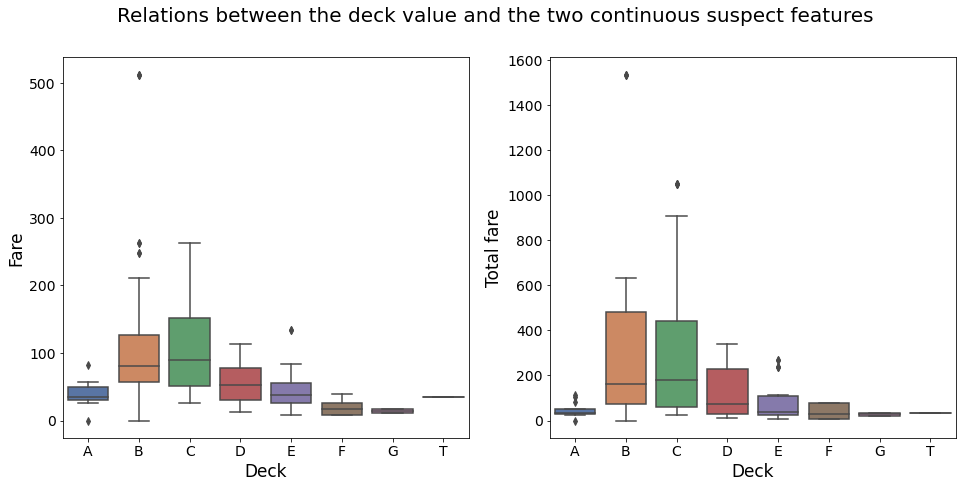

In [22]:
# Firstly, let us inspect the relations solely by looking at the charts
    # Continuous
    
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
plt.suptitle("Relations between the deck value and the two continuous suspect features", fontsize=20)

sb.boxplot(x="Deck", y="Fare", data=sub_df, ax=axs[0])
sb.boxplot(x="Deck", y="TotalFare", data=sub_df, ax=axs[1])

axs[0].set_xlabel("Deck", fontsize=17)
axs[0].set_ylabel("Fare", fontsize=17)
axs[0].tick_params(labelsize=14)

axs[1].set_xlabel("Deck", fontsize=17)
axs[1].set_ylabel("Total fare", fontsize=17)
axs[1].tick_params(labelsize=14)

plt.show()

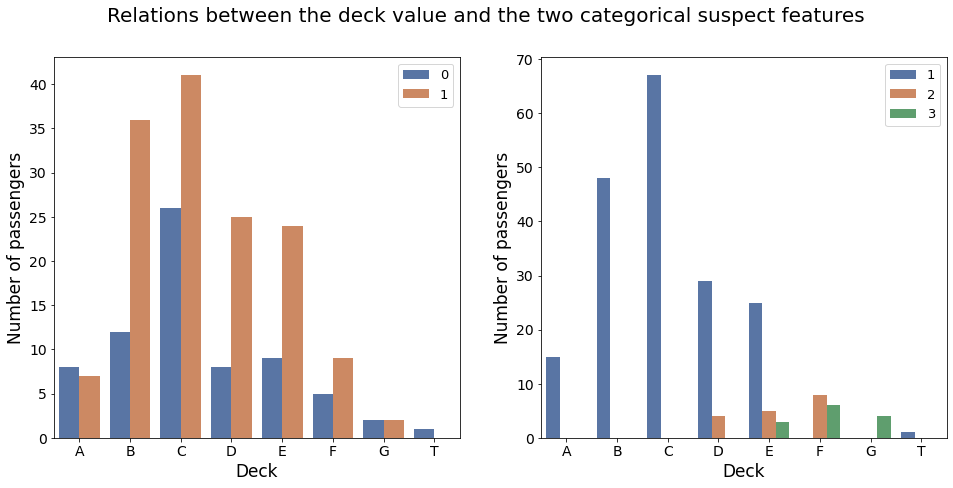

In [23]:
# Firstly, let us inspect the relations solely by looking at the charts
    # Categorical
    
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
plt.suptitle("Relations between the deck value and the two categorical suspect features", fontsize=20)

sb.countplot(x="Deck", data=sub_df, hue="Survived", ax=axs[0])
sb.countplot(x="Deck", data=sub_df, hue="Pclass", ax=axs[1])

axs[0].set_xlabel("Deck", fontsize=17)
axs[0].set_ylabel("Number of passengers", fontsize=17)
axs[0].tick_params(labelsize=14)
axs[0].legend(loc=1, fontsize=13)

axs[1].set_xlabel("Deck", fontsize=17)
axs[1].set_ylabel("Number of passengers", fontsize=17)
axs[1].tick_params(labelsize=14)
axs[1].legend(loc=1, fontsize=13)

plt.show()

In [24]:
# Although the missing Deck values could be filled with modus based
# on some of the variables above, it seems wiser to fill in the missing values
# with the label missing and then try to label the Deck variable using vector NN embedding
# because there seems to be multiple relationships involved among the categories

# The neural network should be way stronger in terms of encoding the similarities between
# different categories, therefore this seems like an extremely ideal use-case scenario

df["Deck"].fillna("Missing", inplace=True)

<h3>Age</h3>

In [25]:
# Entries in the age column will be filled based on the median age

# To make the approximation a bit more precise, we will try to cluster specific groups based on correlation
# and then use their age median instead of the general one
    # Obviously, we are not allowed to use the Sex attribute for this purpose
    # We assume that attributes Ticket and Embarked will not be correlated with Age

# Alternative approach: Scrape the age data from the internet 
# Alternative approach: Instead of median, generate a random number within 1 std from mean of the specific group

In [26]:
# The distribution of the general age should not change drastically - save this for later for comparison
sub_df = df["Age"].dropna()

In [27]:
# Find out features with highest correlation to Age
corr = df.drop(columns=["Embarked", "Sex"]).corr().abs()
corr.loc["Age"].sort_values(ascending=False)

Age           1.000000
Pclass        0.369226
SibSp         0.308247
FamilySize    0.301914
GroupSize     0.253507
Parch         0.189119
Alone         0.183206
Fare          0.096067
Survived      0.077221
TotalFare     0.003798
Name: Age, dtype: float64

In [28]:
# Since Pclass is the most correlated attributes to age, it seems wise
# to use this in order to fill in the missing age values by the respective medians

# In order to make the guesswork more precise, we add the Deck feature 
# as the second level to the grouping
    # This has been preffered over SibSp feature since using that for this purpose
    # resulted in a quite significant shift in the distribution of the data (see the chart below)

df.groupby(["Pclass", "Deck"]).Age.agg(["median", "count"])

median  count
Pclass Deck                  
1      A         44.00     12
       B         33.00     46
       C         36.00     57
       D         47.00     27
       E         39.50     24
       Missing   42.00     19
       T         45.00      1
2      D         35.00      4
       E         29.75      4
       F         14.00      8
       Missing   29.00    157
3      E         27.00      3
       F         25.00      3
       G         14.00      4
       Missing   24.00    345

In [29]:
# We fill the missing Age values by medians from respective groups
df["Age"] = df.groupby(["Pclass", "Deck"]).Age.apply(lambda x: x.fillna(x.median()))

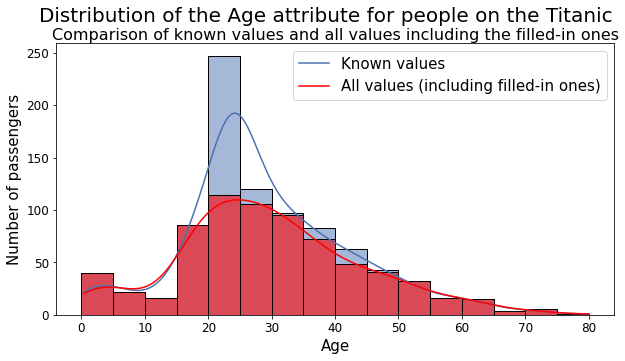

In [30]:
# Check whether the general age distribution has not changed significantly

plt.figure(figsize=(10, 5))
sb.histplot(data=df["Age"], binwidth=5, binrange=(0, 80), kde=True)
sb.histplot(data=sub_df, binwidth=5, binrange=(0, 80), kde=True, color="Red", alpha=0.6)

plt.suptitle("Distribution of the Age attribute for people on the Titanic", fontsize=20)
plt.title("Comparison of known values and all values including the filled-in ones", fontsize=16, pad=1.85)

plt.xlabel("Age", fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel("Number of passengers", fontsize=15)
plt.yticks(fontsize=12)
plt.legend(["Known values", "All values (including filled-in ones)"], fontsize=15)

plt.show()

<h3>Conclusion</h3>

In [31]:
# We have managed to deal with all the missing values
# The remaining "Missing" values in the Deck column are meaningful by themselves
# and it is wiser to let a neural network embed them than to try and fill them
df.isna().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
GroupSize     0
TotalFare     0
FamilySize    0
Alone         0
Deck          0
Sex           0
dtype: int64

<h1>Exploratory Data Analysis</h1>

In [32]:
# Now it is time to examine the relationships between the target variable and other features
# as well as the relationships between other features themselves

<h2>Target Analysis</h2>

<h3>Sex</h3>

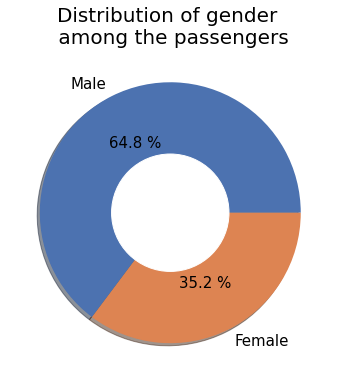

In [33]:
# First, let us perform univariate analysis on the target variable (sex) itself
    # We can see that the ratio is quite strongly sided towards men

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

axs.pie(df["Sex"].value_counts(), labels=df["Sex"].unique(), shadow=True, textprops={"size":15}, autopct="%.1f %%")
axs.add_artist(plt.Circle((0, 0), 0.45, color="white"))
axs.set_title("Distribution of gender \n among the passengers", size=20)

plt.show()

<h3>Sex + Survival</h3>

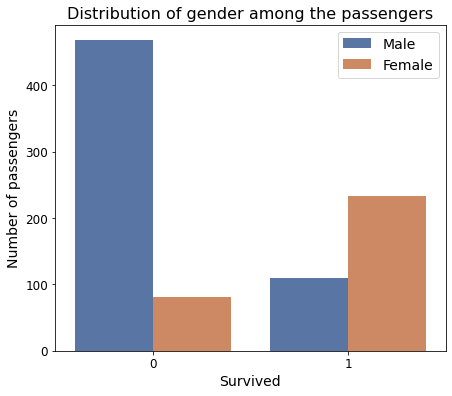

In [34]:
# From the chart, it is visible that our assumption of "Women first" is quite right
# The survival ratio for women is way better than for men
    # The survival variable is therefore extremely meaningful in terms of predicting the gender

plt.figure(figsize=(7, 6))
sb.countplot(x="Survived", data=df, hue="Sex")

plt.title("Distribution of gender among the passengers", fontsize=16)
plt.xlabel("Survived", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("Number of passengers", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

<h3>Sex + Class</h3>

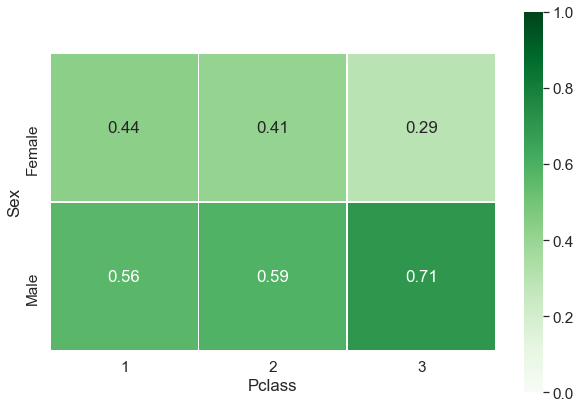

In [35]:
# Here we can see that the distribution of men and women in the first two classes are very similar
# However, the third class is quite different as it shows way higher percentages of men
    # The reason for this is most likely that all the boat workers were probably men
    # This validates one of our initial hypotheses
    
# The difference between the third class and the other two seems to be quite important
# in terms of predicting the gender feature, however it might be wise to experiment with
# grouping the two classes in one since the distribution of genders is almost the same

plt.figure(figsize=(10, 7))
sb.set(font_scale=1.4)
sb.heatmap(pd.crosstab(index=df["Sex"], columns=df["Pclass"], normalize="columns"), 
           vmin=0, vmax=1, square=True, cmap="Greens", annot=True, linewidths=1)


plt.show()

<h3>Sex + Age</h3>

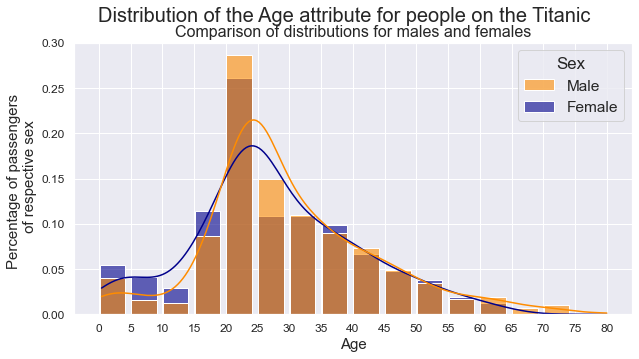

In [36]:
# Based on this chart, we can see that the plot is slightly right-skewed for women
# with a significant bump along ages from 0 to 10
    # This tells us that women aboard were in general younger than their counterparts

plt.figure(figsize=(10, 5))
sb.histplot(data=df, x="Age", hue="Sex", stat="probability", kde=True, common_norm=False,
            binwidth=5, binrange=(0, 80), shrink=0.8, palette=["darkorange", "darkblue"], alpha=0.6)

plt.suptitle("Distribution of the Age attribute for people on the Titanic", fontsize=20)
plt.title("Comparison of distributions for males and females", fontsize=16)

plt.xlabel("Age", fontsize=15)
plt.xticks(range(0, 81, 5), fontsize=12)
plt.ylabel("Percentage of passengers \n of respective sex", fontsize=15)
plt.yticks(fontsize=12)

plt.show()

In [37]:
# From the chart above, it is not very clear, whether the Age attribute is 
# really meaningful in terms of predicting the gender

# In order to assess this, we will perform a t-test for these two groups
    # Null hypothesis: The two groups have the same age means
    # The variance of age for these two groups differs by 8 which is negligible
    
# We can see that the p-value for the t-test is lower than 0.05, therefore
# we can reject the null hypothesis and state that age is statistically significant
# in order to predict gender
    # Note, however, that for threshold of 0.01 the test would not pass, therefore
    # it may be worth to experiment with not including the Age variable
    
ttest_ind(df[df["Sex"] == "Male"]["Age"], df[df["Sex"] == "Female"]["Age"])

Ttest_indResult(statistic=2.3738711377078165, pvalue=0.0178142741186936)

<h3>Sex + Embarked </h3>

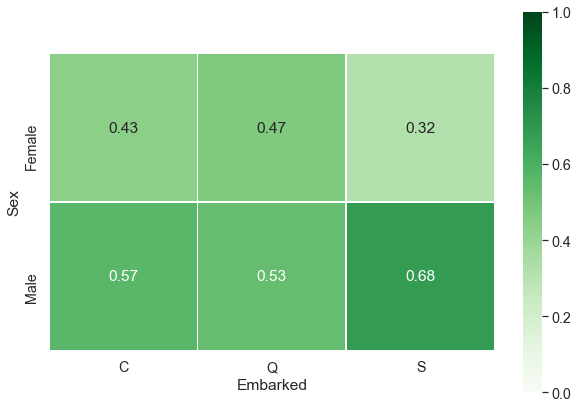

In [38]:
# Under our initial hypothesis, there should be 
# no clear relation between the location of embarkation and the gender of each passenger

# However, it seems like our assumption was wrong, since in Southampton there seems to be 
# a lot higher percentage of men than women that onboarded the ship
    # This relationship seems very similar to that of Class and Gender (see above)
        # There is one possible explanation for this pattern that now seems very clear 
        # and that is Southampton being the starting point, 
        #therefore that is where 3rd class workers boarded
# In terms of the other two boarding locations, however, our assumption seems to be correct
        
# The conclusion from this is the same as for Pclass - the attribute seems quite important
# in order to be able to predict gender of each passenger, however it might be wise to
# try and group the two embarkation locations C and Q

# It might be wise to experiment with keeping only one of the features (presumably Pclass)

plt.figure(figsize=(10, 7))
sb.set(font_scale=1.3)
sb.heatmap(pd.crosstab(index=df["Sex"], columns=df["Embarked"], normalize="columns"), 
           vmin=0, vmax=1, square=True, cmap="Greens", annot=True, linewidths=1)


plt.show()

<h3>Sex + Group and family size</h3>

In [39]:
# Under our initial hypothesis, women should be more likely to travel with family
# and less likely than men to travel alone but also in larger groups 

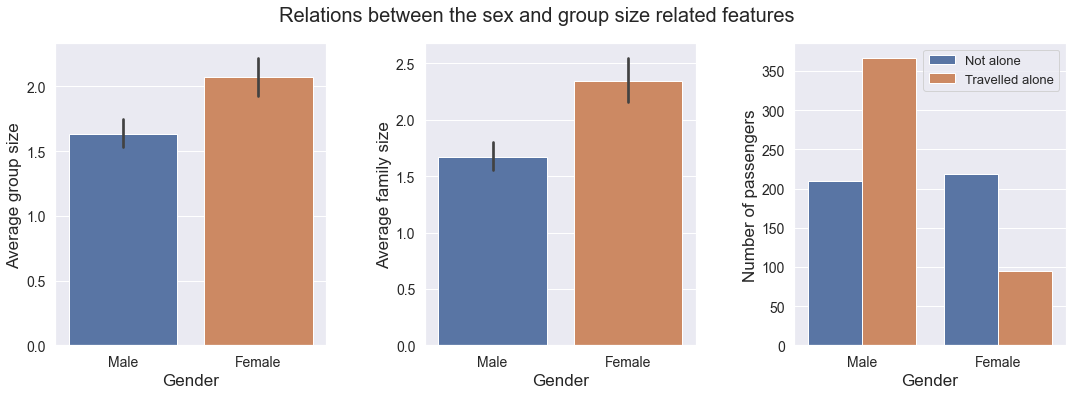

In [40]:
# As seen on the chart below, we can conclude the following statements:
    # Women are likely to travel in larger groups than men
    # Women are likely to travel within bigger families than men
    # Women are far less likely to travel alone than men
        # Only 30 % of women travelled alone, whereas 63 % of men travelled alone

# Based on these findings, all these features seem to be quite relevant in terms of the gender attribute
# By far the most meaningful one seems to be the "Travelled alone" feature

fig, axs = plt.subplots(1, 3, figsize=(16, 7))
plt.suptitle("Relations between the sex and group size related features", fontsize=20, y=0.85)

sb.barplot(x="Sex", y="GroupSize", data=df, ax=axs[0])
sb.barplot(x="Sex", y="FamilySize", data=df, ax=axs[1])
sb.countplot(x="Sex", data=df, hue="Alone", ax=axs[2])

axs[0].set_xlabel("Gender", fontsize=17)
axs[0].set_ylabel("Average group size", fontsize=17)
axs[0].tick_params(labelsize=14)

axs[1].set_xlabel("Gender", fontsize=17)
axs[1].set_ylabel("Average family size", fontsize=17)
axs[1].tick_params(labelsize=14)

axs[2].set_xlabel("Gender", fontsize=17)
axs[2].set_ylabel("Number of passengers", fontsize=17)
axs[2].tick_params(labelsize=14)
axs[2].legend(labels=["Not alone", "Travelled alone"], loc=1, fontsize=13)

fig.tight_layout(pad=3.0)

<h3>Sex + (Total) fare</h3>

In [41]:
# For the purpose of the following charting, we erased the 1 outlier entry in fares
sub_df = df[df["Fare"] < df["Fare"].max()]

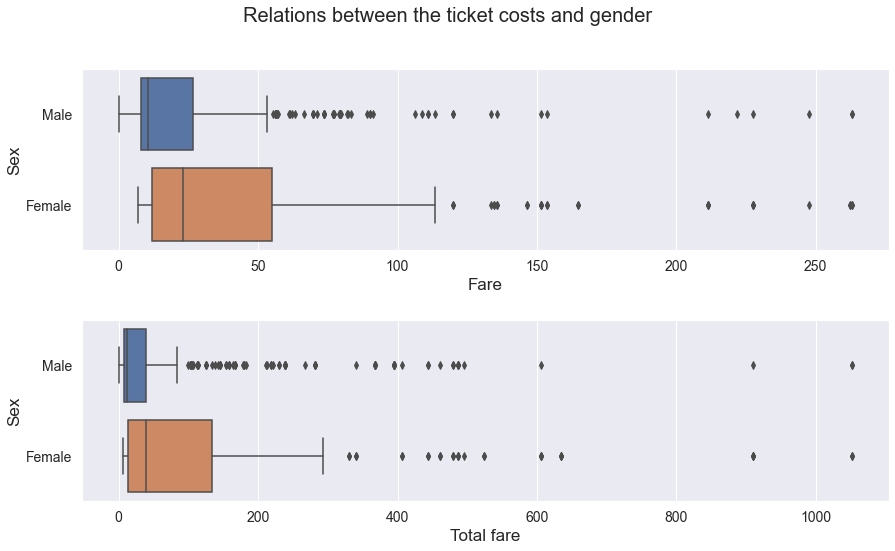

In [42]:
# In the charts below, we can see quite strong difference between the fares 
# for female and male passengers
# The tickets for female passengers tend to be much more expensive in general

fig, axs = plt.subplots(2, 1, figsize=(13, 8))
plt.suptitle("Relations between the ticket costs and gender", fontsize=20)

sb.boxplot(x="Fare", y="Sex", data=sub_df, ax=axs[0], orient="h")
sb.boxplot(x="TotalFare", y="Sex", data=sub_df, ax=axs[1], orient="h")

axs[0].set_xlabel("Fare", fontsize=17)
axs[0].set_ylabel("Sex", fontsize=17)
axs[0].tick_params(labelsize=14)

axs[1].set_xlabel("Total fare", fontsize=17)
axs[1].set_ylabel("Sex", fontsize=17)
axs[1].tick_params(labelsize=14)

fig.tight_layout(pad=1.75)

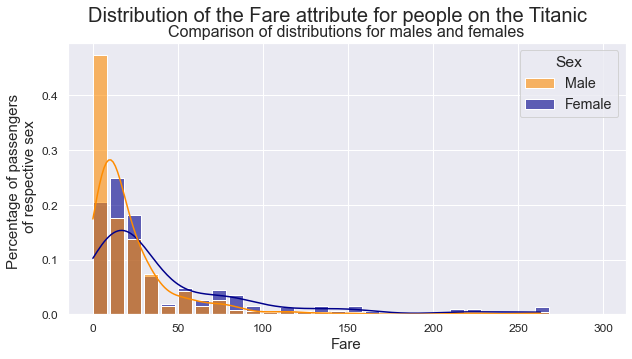

In [43]:
# This relationship might be very interesting to look at from the perspective 
# of the fare distribution

# Using the total fare seems inappropriate here since there are both men and women 
# combined in the groups. However, one could reason that the fare feature
# is meaningless from this perspective for the same reason

plt.figure(figsize=(10, 5))
sb.histplot(data=sub_df, x="Fare", hue="Sex", stat="probability", kde=True, common_norm=False,
            binwidth=10, binrange=(0, 300), shrink=0.8, palette=["darkorange", "darkblue"], alpha=0.6)

plt.suptitle("Distribution of the Fare attribute for people on the Titanic", fontsize=20)
plt.title("Comparison of distributions for males and females", fontsize=16)

plt.xlabel("Fare", fontsize=15)
plt.xticks(range(0, 301, 50), fontsize=12)
plt.ylabel("Percentage of passengers \n of respective sex", fontsize=15)
plt.yticks(fontsize=12)

plt.show()

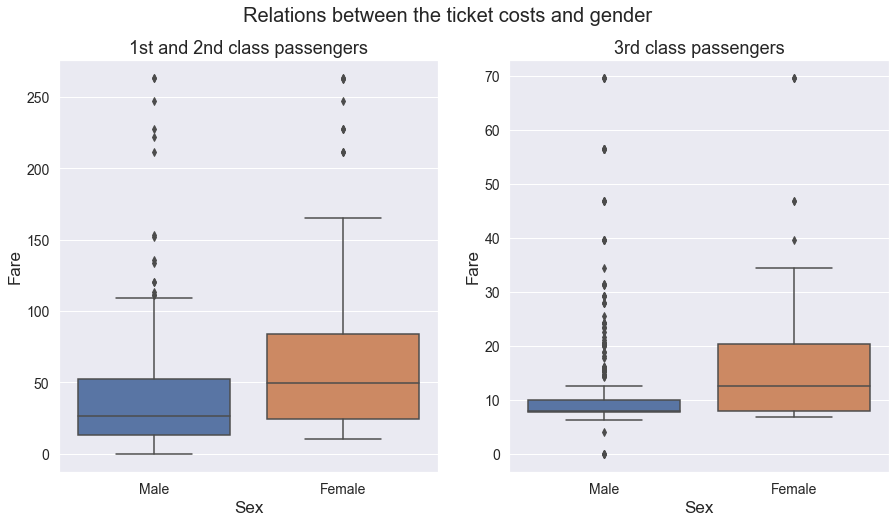

In [44]:
# Both of the approaches above show that women tend to pay more
# for their tickets, however it is important to not forget the already
# discovered relationship between Sex and Pclass

# For this reason, it might be more appropriate to inspect the fares without the 3rd class
# and for the 3rd class separately

fig, axs = plt.subplots(1, 2, figsize=(13, 8))
plt.suptitle("Relations between the ticket costs and gender", fontsize=20, y=0.93)

sb.boxplot(x="Sex", y="Fare", data=sub_df[sub_df["Pclass"] < 3].sort_values("Sex", ascending=False), ax=axs[0], orient="v")
sb.boxplot(x="Sex", y="Fare", data=sub_df[sub_df["Pclass"] == 3].sort_values("Sex", ascending=False), ax=axs[1], orient="v")

axs[0].set_title("1st and 2nd class passengers", fontsize=18)
axs[0].set_xlabel("Sex", fontsize=17)
axs[0].set_ylabel("Fare", fontsize=17)
axs[0].tick_params(labelsize=14)

axs[1].set_title("3rd class passengers", fontsize=18)
axs[1].set_xlabel("Sex", fontsize=17)
axs[1].set_ylabel("Fare", fontsize=17)
axs[1].tick_params(labelsize=14)

fig.tight_layout(pad=1.75)

In [45]:
# Using this approach, the Fares are way closer to one another
# Once again, it is time to test, whether there is statistical significance

# The t-test will be performed on these subsets with separated classes
# since if the Fare attributes are only relevant when there is class involved, 
# then there is no point in keeping it in addition to the Pclass feature

# Based on the result below, the only statistically insignificant features are total fares
# for 3rd class passengers
# Therefore, the conclusion is, that the Fare and Total Fare attributes are relevant in terms 
# of predicting the gender, but the total fare feature drop might be the thing to experiment with 

sub_df3 = df[df["Pclass"] == 3]
sub_df12 = df[df["Pclass"] < 3]

print(ttest_ind(sub_df3[sub_df3["Sex"] == "Male"]["Fare"], sub_df3[sub_df3["Sex"] == "Female"]["Fare"], equal_var=False))
print(ttest_ind(sub_df3[sub_df3["Sex"] == "Male"]["TotalFare"], sub_df3[sub_df3["Sex"] == "Female"]["TotalFare"], equal_var=False))

print(ttest_ind(sub_df12[sub_df12["Sex"] == "Male"]["Fare"], sub_df12[sub_df12["Sex"] == "Female"]["Fare"], equal_var=False))
print(ttest_ind(sub_df12[sub_df12["Sex"] == "Male"]["TotalFare"], sub_df12[sub_df12["Sex"] == "Female"]["TotalFare"], equal_var=False))

Ttest_indResult(statistic=-2.9839708596777315, pvalue=0.0031086850672929476)
Ttest_indResult(statistic=-1.8419029194266952, pvalue=0.06661015431320463)
Ttest_indResult(statistic=-3.5048983195478045, pvalue=0.0005180957766701713)
Ttest_indResult(statistic=-3.2306894259333574, pvalue=0.0013584153430650494)


<h3>Sex + Deck</h3>

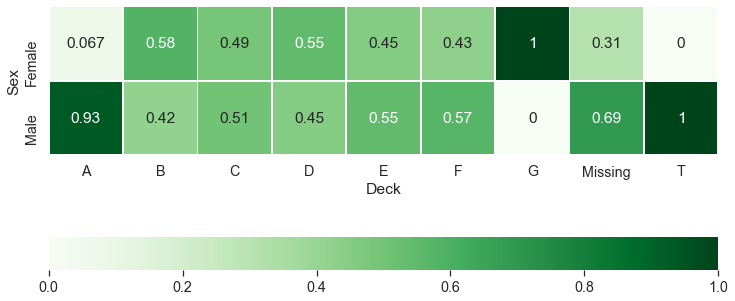

In [46]:
# Based on the heatmap below, it seems that the information about the deck
# might be a very important one in terms of predicting passenger's gender

# It is important to point out, that decks T and G together only occur among 5 passengers

# Apart from T and G, the most obvious pattern can be seen within the A deck that is almost
# solely for men

# The decks B and D, on the other hand, seem to be more occupied by women, which is a very
# meaningful piece of information since it opposes the general distribution of men x women

# Decks C, E and F seem to resemble the general gender distribution

# One specific category is the "Missing" deck, which seems to occur way more among men
# This might be due to the number of men aboard and also might be in correlation to survival
# since the people with missing Deck attribute are mostly the ones who have not survived (70 %)

plt.figure(figsize=(12, 10))
sb.set(font_scale=1.3)
sb.heatmap(pd.crosstab(index=df["Sex"], columns=df["Deck"], normalize="columns"), 
           vmin=0, vmax=1, square=True, cmap="Greens", annot=True, 
           linewidths=1, cbar_kws={"orientation": "horizontal"})


plt.show()

<h1>Predictive analysis</h1>

<h2>General variable encoding and manipulation</h2>

<h3>Target variable</h3>

In [47]:
# The most straightforward variable to be encoded is the binary target variable
df["Sex"].replace({"Male": 0, "Female": 1}, inplace=True)

<h3>Embarked encoding</h3>

In [48]:
# For the "Embarked" feature, we have decided to group the 2 locations (Q, C) together
# and therefore make "Embarked a binary nominal feature"

# This approach has been chosen due to this feature's low dimensionality
# and based on the conclusions from the exploratory data analysis

df.rename({"Embarked": "EmbarkedS"}, axis=1, inplace=True)
df["EmbarkedS"].replace({"Q": 0, "C": 0, "S": 1}, inplace=True)

<h3>Correlation analysis</h3>

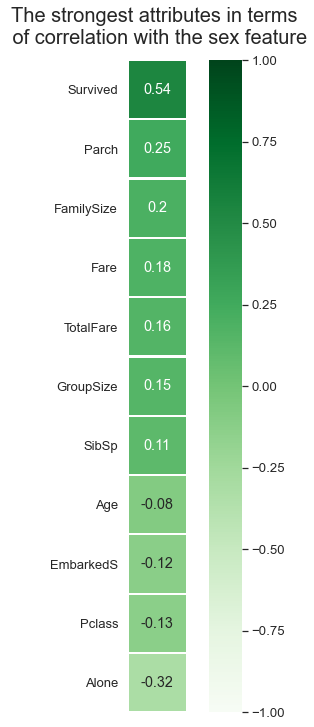

In [49]:
# Take a look at the correlation of each attribute with the sex of each passenger

sub_df = df.copy()
sex_corr = pd.DataFrame(sub_df.corr().round(2).drop(["Sex"], axis=0)["Sex"].sort_values(ascending=False))
sex_corr.rename({"Sex": ""}, axis=1, inplace=True)

plt.figure(figsize=(8, 12))
sb.set(font_scale=1.2)

sb.heatmap(sex_corr, vmin=-1, vmax=1,
          square=True, cmap="Greens", annot=True, linewidths=1.2)

plt.title("The strongest attributes in terms \n of correlation with the sex feature", fontsize=20, pad=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)

plt.show()

<h3>Handling the statistical errors in continuous variables</h3>

In [50]:
# Since the continuous variables (namely Age, Fare & TotalFare) are strongly unevenly distributed
# we should scale them in order to get closer to the normal distribution
# The same goes for high ordinality categorical variables (GroupSize, FamilySize)

scaler = StandardScaler()

for feature in ["Age", "Fare", "TotalFare", "GroupSize"]:
    df[feature] = scaler.fit_transform(df[feature].values.reshape(-1, 1))

<h2>Decision Tree</h2>

In [51]:
# The following data-manipulation will be specific to the decision tree model
# and therefore we have to copy the datasets in order to preserve the original
# for the neural network that we will follow-up with

X_tree = df.drop(columns="Sex").copy()
y_tree = df["Sex"].copy()

<h3>Deck encoding</h3>

In [52]:
# Since the tree based models tend to not do well using one-hot encoding
# we will use target mean encoding based on the results for the train dataset

sub_df = pd.concat([X_tree, y_tree], axis=1)
enc = sub_df[sub_df["Sex"] == 1].groupby(["Deck"]).size()/sub_df.groupby(["Deck"]).size()
for deck in df["Deck"].unique():
    if np.isnan(enc[deck]):
        enc[deck] = 0

X_tree["Deck"] = X_tree["Deck"].map(enc)

<h3>Model creation</h3>

In [53]:
# For some first model creation we will split the dataset but this will not be necessary
# later on since we will be using k-fold-cross-validation in order to preserve
# as many entries as possible (this is desirable since the dataset is quite small)
X_train_tree, X_val_tree, y_train_tree, y_val_tree = train_test_split(X_tree, y_tree, 
                                                                      test_size=0.3, random_state=10)

Baseline accuracy (Predict always male): 0.66 
Random Forest AUC:  0.83 (mean for 10-fold-cross-validation)


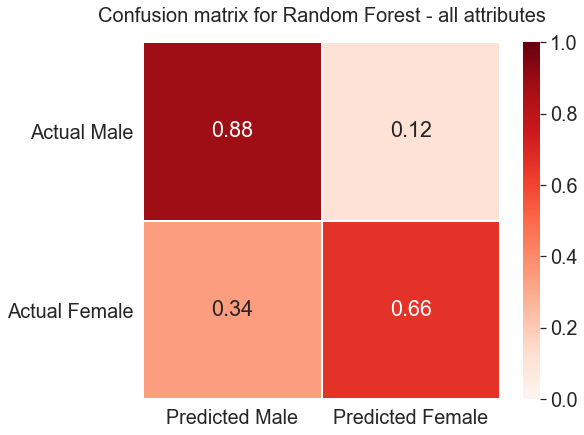

In [54]:
rfc = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion="gini", random_state=10)

rfc.fit(X_train_tree, y_train_tree)
rfc_preds = rfc.predict(X_val_tree)

print("Baseline accuracy (Predict always male): 0.66", 
      "\nRandom Forest AUC: ", round(cross_val_score(rfc, X_tree, y_tree, 
                                                     cv=10, scoring="roc_auc", n_jobs=-1).mean(), 2), "(mean for 10-fold-cross-validation)")

rfc = RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=10)

rfc.fit(X_train_tree, y_train_tree)
rfc_preds = rfc.predict(X_val_tree)

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(y_val_tree, rfc_preds, normalize="true"),
          vmin=0, vmax=1, cmap="Reds", square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted Male", "Predicted Female"],
          yticklabels=["Actual Male", "Actual Female"])

plt.title("Confusion matrix for Random Forest - all attributes", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h3>Hyperparameter testing</h3>

In [55]:
# Since the dataset size is quite small, it might be wise to experiment
# with k-fold-cross-validation in order to get a larger training dataset

rfc = RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=10)

print("Baseline accuracy (Predict always male): 0.66", 
      "\nRandom Forest AUC: ", round(cross_val_score(rfc, X_tree, y_tree, 
                                                       scoring="roc_auc", cv=10, n_jobs=-1).mean(), 2), "(mean for 10-fold-cross-validation)")

Baseline accuracy (Predict always male): 0.66 
Random Forest AUC:  0.83 (mean for 10-fold-cross-validation)


In [56]:
# Now we would like to use Grid Search to fine-tune the hyperparameters

n_estimators = [25, 50, 100]
max_depth = [None, 5, 10, 15]
min_samples_leaf = [2, 3, 4]
bootstrap = [True, False]
criterion = ["gini", "entropy"]

grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
           min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, criterion=criterion)

In [57]:
rfc = RandomForestClassifier(random_state=10)
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, cv=3, scoring="roc_auc", verbose=3, n_jobs=-1)

grid_result = grid_search.fit(X_tree, y_tree)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [58]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.8625920100337199 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 50}


<h3>Feature selection & manipulation</h3>

Baseline accuracy (Predict always male): 0.66 
Random Forest AUC:  0.86 (mean for 10-fold-cross-validation)


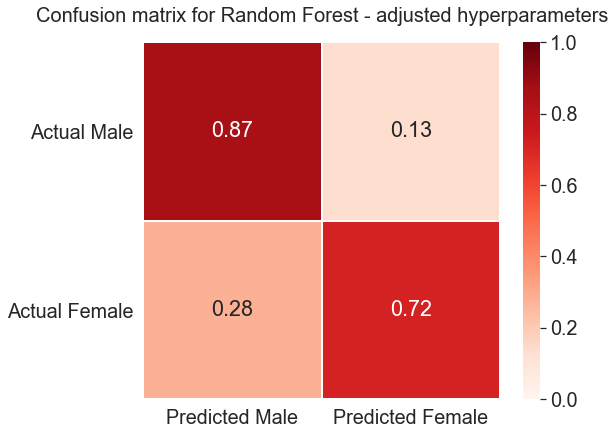

In [59]:
# As can be seen above, using the best set of hyperparameters, we can achieve accuracy of ca. 86 %
rfc = RandomForestClassifier(n_estimators=grid_result.best_params_["n_estimators"], 
                             max_depth=grid_result.best_params_["max_depth"],
                             min_samples_leaf=grid_result.best_params_["min_samples_leaf"],
                             bootstrap=grid_result.best_params_["bootstrap"],
                             criterion=grid_result.best_params_["criterion"],
                             n_jobs=-1, random_state=10)

print("Baseline accuracy (Predict always male): 0.66", 
      "\nRandom Forest AUC: ", round(cross_val_score(rfc, X_tree, y_tree, 
                                                       cv=10, scoring="roc_auc", n_jobs=-1).mean(), 2), "(mean for 10-fold-cross-validation)")

rfc = RandomForestClassifier(n_estimators=grid_result.best_params_["n_estimators"], 
                             max_depth=grid_result.best_params_["max_depth"],
                             min_samples_leaf=grid_result.best_params_["min_samples_leaf"],
                             bootstrap=grid_result.best_params_["bootstrap"],
                             criterion=grid_result.best_params_["criterion"],
                             n_jobs=-1, random_state=10)
rfc.fit(X_train_tree, y_train_tree)
rfc_preds = rfc.predict(X_val_tree)

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(y_val_tree, rfc_preds, normalize="true"),
          vmin=0, vmax=1, cmap="Reds", square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted Male", "Predicted Female"],
          yticklabels=["Actual Male", "Actual Female"])

plt.title("Confusion matrix for Random Forest - adjusted hyperparameters", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

In [60]:
# For this respective model, we would like to perform feature selection
importances = list(rfc.feature_importances_)
importances = pd.DataFrame([round(i, 3) for i in importances], index=X_tree.columns)
importances = importances.sort_values(by=0, ascending=False).rename({0: "Importance"}, axis=1)
importances

,Importance
Survived,0.312
TotalFare,0.150
Fare,0.144
Age,0.096
FamilySize,0.060
Alone,0.048
Parch,0.040
GroupSize,0.039
Pclass,0.038
Deck,0.028


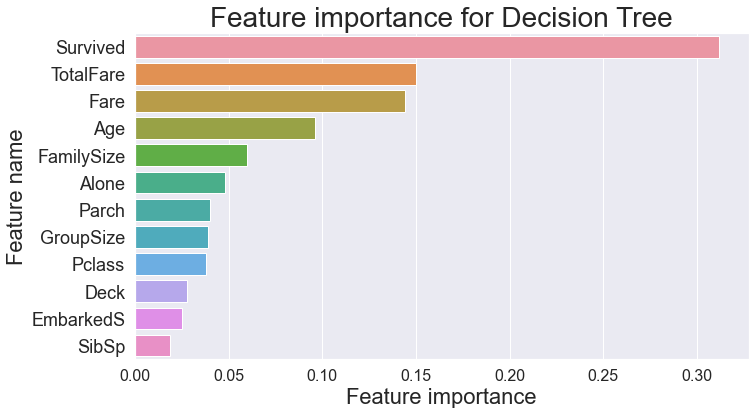

In [61]:
plt.figure(figsize=(11, 6))
sb.barplot(x="Importance", y=importances.index, data=importances)

plt.title("Feature importance for Decision Tree", fontsize=28)
plt.xlabel("Feature importance", fontsize=22)
plt.xticks(fontsize=16)
plt.ylabel("Feature name", fontsize=22)
plt.yticks(fontsize=18)

plt.show()

In [62]:
# If we combine the results from our EDA with the feature importances, 
# we come to a conclusion that there are few steps worth a try

# Try to drop Deck, EmbarkedS and SibSp completely due to low feature importance
X_tree = X_tree.drop(columns=["Deck", "SibSp", "EmbarkedS"])

In [63]:
X_train_tree, X_val_tree, y_train_tree, y_val_tree = train_test_split(X_tree, y_tree, test_size=0.33, random_state=10)

Baseline accuracy (Predict always male): 0.66 
Random Forest AUC:  0.86 (mean for 10-fold-cross-validation)


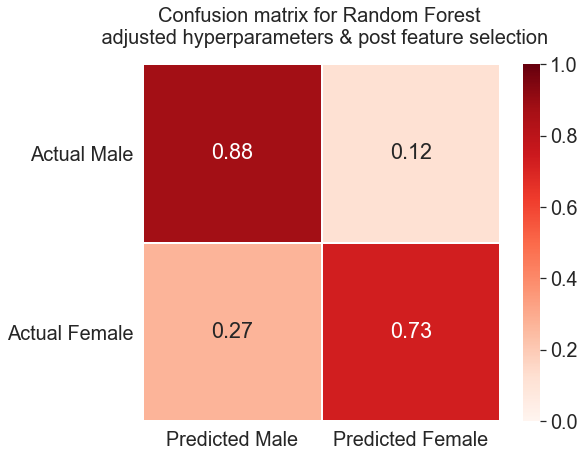

In [64]:
# As can be seen in this block, using the best set of hyperparameters
# and after performing some feature engineering and selection
# we can achieve accuracy of ca. 86 %
rfc = RandomForestClassifier(n_estimators=grid_result.best_params_["n_estimators"], 
                             max_depth=grid_result.best_params_["max_depth"],
                             min_samples_leaf=grid_result.best_params_["min_samples_leaf"],
                             bootstrap=grid_result.best_params_["bootstrap"],
                             criterion=grid_result.best_params_["criterion"],
                             n_jobs=-1, random_state=10)

print("Baseline accuracy (Predict always male): 0.66", 
      "\nRandom Forest AUC: ", round(cross_val_score(rfc, X_tree, y_tree, 
                                                       cv=10, scoring="roc_auc", n_jobs=-1).mean(), 2), "(mean for 10-fold-cross-validation)")

rfc = RandomForestClassifier(n_estimators=grid_result.best_params_["n_estimators"], 
                             max_depth=grid_result.best_params_["max_depth"],
                             min_samples_leaf=grid_result.best_params_["min_samples_leaf"],
                             bootstrap=grid_result.best_params_["bootstrap"],
                             n_jobs=-1, random_state=10)
rfc.fit(X_train_tree, y_train_tree)
rfc_preds = rfc.predict(X_val_tree)

plt.figure(figsize=(8, 8))

sb.set(font_scale=1.8)
sb.heatmap(confusion_matrix(y_val_tree, rfc_preds, normalize="true"),
          vmin=0, vmax=1, cmap="Reds", square=True, linewidths=1, annot=True, cbar_kws={"shrink": 0.82},
          xticklabels=["Predicted Male", "Predicted Female"],
          yticklabels=["Actual Male", "Actual Female"])

plt.title("Confusion matrix for Random Forest \n adjusted hyperparameters & post feature selection", fontsize=20, pad=20)
plt.yticks(rotation=0)

plt.show()

<h2>Neural Networks</h2>

<h3>Data preparation</h3>

In [65]:
# The following data-manipulation will be specific to the neural network model
# and therefore we have to copy the datasets in order to preserve the original

X_net = df.drop(columns="Sex").copy()
y_net = df["Sex"].copy()

# Take the nominal categorical features as continuous since that is 
# the preferred way for a neural network and scale them

scaler = StandardScaler()

for feature in ["SibSp", "Parch", "FamilySize"]:
    X_net[feature] = scaler.fit_transform(X_net[feature].values.reshape(-1, 1))

In [66]:
# The deck variable seem to show signs of strong similarities among different deck categories
# This seems like an ideal candidate to encode using embedding, this way, we should be able
# to capture the relationships between the individual decks

# Note: This is a step to experiment with in case we need to improve our model's performance

# As a rule of thumb for our dimensionality reduction, we will use 3 dimensions,
# which is the square root of the number of entries in the deck variable
x = len(X_net["Deck"].unique())
n = round(np.sqrt(x))

# The categories need to be label encoded in order to perform the embedding
encoder = LabelEncoder()
X_net["Deck"] = encoder.fit_transform(X_net["Deck"])

<h3>Model creation</h3>

In [67]:
# In order to be able to easily tune the hyperparameters, we will create a model-creating function
def build_net(dense_layers=1, dense_dim=50, embedding_dim=n, d=0.5, lr=0.001):
    
    # The first step is to create the network branch for the Deck feature embedding
    deck_input = Input(name="Deck_input", shape=[1])
    deck_embedding = Embedding(input_dim=x+1, 
                               output_dim=embedding_dim,
                               name="Deck_embedding")(deck_input)
    flatten = Flatten()(deck_embedding)

    # And then the branch for the rest of the variables
    rest_input = Input(shape=[len(X_net.columns)-1], name="Rest_input")
    
    # The following step is to concatenate the branches
    concatenate = Concatenate(name="Concatenate")([flatten, rest_input])
    
    # And continue as with a normal neural network
    dense = Dense(dense_dim, activation="relu")(concatenate)
    drop = Dropout(d)(dense)
    
    for i in range(dense_layers - 1):
        dense = Dense(dense_dim, activation="relu")(drop)
        drop = Dropout(d)(dense)
    
    # Add an output layer
    y = Dense(1, activation="sigmoid")(drop)
    
    # And put it all together
    model = keras.Model(inputs=[deck_input, rest_input],
                        outputs=y)
    model.compile(loss="binary_crossentropy", 
                  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr), metrics=["AUC"])
    
    return model

In [68]:
model = build_net(dense_layers=2, dense_dim=30)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Deck_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Deck_embedding (Embedding)     (None, 1, 3)         30          ['Deck_input[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 3)            0           ['Deck_embedding[0][0]']         
                                                                                                  
 Rest_input (InputLayer)        [(None, 11)]         0           []                               
                                                                                              

In [69]:
# Some first looks at the model performance
training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                     epochs=25, batch_size=32, validation_split=0.4, shuffle=True)
np.mean(training.history["val_auc"][-5:])

Epoch 1/25
17/17 [==============================] - 1s 17ms/step - loss: 0.8879 - auc: 0.4986 - val_loss: 0.7068 - val_auc: 0.6006
Epoch 2/25
17/17 [==============================] - 0s 5ms/step - loss: 0.7508 - auc: 0.5327 - val_loss: 0.6402 - val_auc: 0.6637
Epoch 3/25
17/17 [==============================] - 0s 3ms/step - loss: 0.7686 - auc: 0.5198 - val_loss: 0.6089 - val_auc: 0.7464
Epoch 4/25
17/17 [==============================] - 0s 3ms/step - loss: 0.7167 - auc: 0.5329 - val_loss: 0.5900 - val_auc: 0.7799
Epoch 5/25
17/17 [==============================] - 0s 3ms/step - loss: 0.6679 - auc: 0.5956 - val_loss: 0.5738 - val_auc: 0.7991
Epoch 6/25
17/17 [==============================] - 0s 4ms/step - loss: 0.6389 - auc: 0.6361 - val_loss: 0.5619 - val_auc: 0.8042
Epoch 7/25
17/17 [==============================] - 0s 4ms/step - loss: 0.6594 - auc: 0.6058 - val_loss: 0.5540 - val_auc: 0.8066
Epoch 8/25
17/17 [==============================] - 0s 4ms/step - loss: 0.6556 - auc: 0.6

0.8322327613830567

<h3>Hyperparameter testing</h3>

In [70]:
# Since GridSearchCV does not support an input of multiple dataframes as X, we will improvise
# it is obviously way slower due to the inability to use n_jobs=-1

# First step is to find general parameters - epochs and batch_size 

val_aucs = {}

for bs in [16, 32, 64]:
    for epoch in [50, 75, 100]:
        model = build_net(dense_layers=3, dense_dim=50)
        training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                             epochs=epoch, batch_size=bs, validation_split=0.4, 
                             use_multiprocessing=True, verbose=0, shuffle=True)
        val_aucs[(bs, epoch)] = np.mean(training.history["val_auc"])

best_batch, best_epoch = max(val_aucs, key=val_aucs.get)
val_aucs 

{(16, 50): 0.843381735086441,
 (16, 75): 0.8450577044487,
 (16, 100): 0.8498039734363556,
 (32, 50): 0.8372166895866394,
 (32, 75): 0.8445657499631246,
 (32, 100): 0.8380249279737473,
 (64, 50): 0.8365467095375061,
 (64, 75): 0.8190446869532267,
 (64, 100): 0.8357324022054672}

In [71]:
# Next up are some strong fundamentals of the network - number of dense layers and their dimensions

val_aucs = {}

for layers in [1, 2, 3]:
    for dense_dims in [25, 50, 100, 200]:
        model = build_net(dense_layers=layers, dense_dim=dense_dims)
        training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                             epochs=best_epoch, batch_size=best_batch, validation_split=0.4, 
                             use_multiprocessing=True, verbose=0, shuffle=True)
        val_aucs[(layers, dense_dims)] = np.mean(training.history["val_auc"])

best_layers, best_dense_dim = max(val_aucs, key=val_aucs.get)
val_aucs 

{(1, 25): 0.8413349533081055,
 (1, 50): 0.8452221298217774,
 (1, 100): 0.8504993540048599,
 (1, 200): 0.8532019931077958,
 (2, 25): 0.8447340375185013,
 (2, 50): 0.8515045011043548,
 (2, 100): 0.8520990109443665,
 (2, 200): 0.8491719180345535,
 (3, 25): 0.8411873996257782,
 (3, 50): 0.8474114632606506,
 (3, 100): 0.8489385133981705,
 (3, 200): 0.8483917552232743}

In [72]:
# Then some technicalities - embedding dimensions and dropout rate

val_aucs = {}

for embedding_dims in [2, 3, 4]:
    for ds in [0.3, 0.5, 0.7]:
        model = build_net(dense_layers=best_layers, dense_dim=best_dense_dim, 
                          embedding_dim=embedding_dims, d=ds)
        training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                             epochs=best_epoch, batch_size=best_batch, validation_split=0.4, 
                             use_multiprocessing=True, verbose=0, shuffle=True)
        val_aucs[(embedding_dims, ds)] = np.mean(training.history["val_auc"])

best_embedding_dim, best_d = max(val_aucs, key=val_aucs.get)
val_aucs 

{(2, 0.3): 0.8542341494560242,
 (2, 0.5): 0.852429171204567,
 (2, 0.7): 0.8538778698444367,
 (3, 0.3): 0.8529743129014968,
 (3, 0.5): 0.8511221152544022,
 (3, 0.7): 0.8497115081548691,
 (4, 0.3): 0.8522403001785278,
 (4, 0.5): 0.8508411419391632,
 (4, 0.7): 0.8523406392335892}

In [73]:
# And last but not least another important fundamentals - learning rate & callback patience

val_aucs = {}

for lrs in [round(0.1**i, 4) for i in range(2, 5)]:
        model = build_net(dense_layers=best_layers, dense_dim=best_dense_dim, 
                          embedding_dim=best_embedding_dim, d=best_d, lr=lrs)
        training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                             epochs=best_epoch, batch_size=best_batch, validation_split=0.4, 
                             use_multiprocessing=True, verbose=0, shuffle=True)
        val_aucs[lrs] = np.mean(training.history["val_auc"])

best_lr = max(val_aucs, key=val_aucs.get)
val_aucs 

{0.01: 0.8304973858594894,
 0.001: 0.8504451608657837,
 0.0001: 0.8258913922309875}

In [74]:
print(f"Best parameters of our neural network: \n - Batch size: {best_batch} \n - Number of epochs: {best_epoch}",
     f"\n - Number of dense layers: {best_layers} \n - Dimension of the dense layers (number of neurons in each): {best_dense_dim}",
     f"\n - Embedding dimension for the Deck variable: {best_embedding_dim} \n - Dropout rate: {best_d}",
     f"\n - Learning rate: {best_lr}")

Best parameters of our neural network: 
 - Batch size: 16 
 - Number of epochs: 100 
 - Number of dense layers: 1 
 - Dimension of the dense layers (number of neurons in each): 200 
 - Embedding dimension for the Deck variable: 2 
 - Dropout rate: 0.3 
 - Learning rate: 0.001


In [81]:
# Create an early-stopping callback to prevent overfitting
callback1 = keras.callbacks.EarlyStopping(monitor="auc", patience=best_epoch/5)
callback2 = keras.callbacks.EarlyStopping(monitor="val_auc", patience=best_epoch/10)

# So now the "optimal model" in terms of it's hyperparameters:

model = build_net(dense_layers=best_layers, dense_dim=best_dense_dim, 
                  embedding_dim=best_embedding_dim, d=best_d)

training = model.fit([X_net["Deck"], X_net.drop(columns="Deck")], y_net, 
                     epochs=best_epoch, batch_size=best_batch, validation_split=0.33, 
                     use_multiprocessing=True, verbose=0, shuffle=True, callbacks=[callback1, callback2])

np.mean(training.history["val_auc"][-10:])

0.8653994500637054

In [77]:
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Deck_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Deck_embedding (Embedding)     (None, 1, 2)         20          ['Deck_input[0][0]']             
                                                                                                  
 flatten_35 (Flatten)           (None, 2)            0           ['Deck_embedding[0][0]']         
                                                                                                  
 Rest_input (InputLayer)        [(None, 11)]         0           []                               
                                                                                           

In [78]:
# Extract the embeddings for the individual Deck values
print(df["Deck"].unique())
model.layers[1].get_weights()

['Missing' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


[array([[ 0.49539626,  0.49024937],
        [ 0.04152959,  0.0350783 ],
        [ 0.12311672,  0.19758052],
        [ 0.12140689,  0.02085169],
        [ 0.05922127,  0.27880734],
        [ 0.3184899 , -0.31892172],
        [-0.80103415, -0.69514394],
        [ 0.03921571,  0.08218519],
        [ 0.38370547,  0.34728676],
        [-0.00724703, -0.0481575 ]], dtype=float32)]

<h1>Final evaluation and comparison</h1>

In [79]:
# As we can see below, we have managed to outclass the Random Forest model

# It is important to note that the predictions from the nural network are
# in form of probabilities and therefore a lot of information gets lost when
# trying to map them to binary outputs - that is why we will not use the 
# confusion matrix comparison

# There has been no feature extraction/selection for the neural network
# and therefore there is a great room for improvement - it might be possible
# to reach accuracies of around 90 % and with much less complex architecture
# due to the number of feature being trimmed

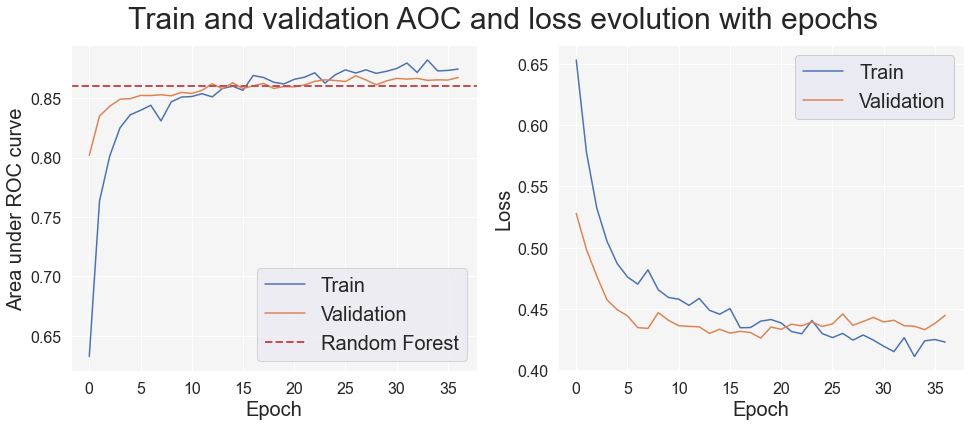

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Train and validation AOC and loss evolution with epochs", fontsize=30, y=0.97)

axs[0].plot(training.history["auc"])
axs[0].plot(training.history["val_auc"])
axs[0].axhline(y=0.86, color="r", linestyle="--", linewidth=2)

axs[1].plot(training.history["loss"])
axs[1].plot(training.history["val_loss"])

axs[0].set_xlabel("Epoch", fontsize=20)
axs[0].set_ylabel("Area under ROC curve", fontsize=20)
axs[0].tick_params(labelsize=16)
axs[0].legend(["Train", "Validation", "Random Forest"], loc="lower right", fontsize=20)
axs[0].set_facecolor("whitesmoke")

axs[1].set_xlabel("Epoch", fontsize=20)
axs[1].set_ylabel("Loss", fontsize=20)
axs[1].tick_params(labelsize=16)
axs[1].legend(["Train", "Validation"], loc="upper right", fontsize=20, framealpha=1)
axs[1].set_facecolor("whitesmoke")

plt.show()

<h1>Hypotheses after examination</h1>

    - Sex is very strongly correlated to the survived feature both in terms of pure correlation and Random forest feature importance
    - Women travelled in much bigger groups & families and were much less likely to travel alone than men
    - Some decks were solely for men, whereas some decks seemed to be preferred by women, however this feature did not seem very significant
    - The 3rd class indeed had way higher rate of men than the other 2
    - The embarkation location actually was actually quite relevant and showed similar behaviour as the class attribute - a very plausible explanation is that all the ship staff (mostly (if not only) men) embarked at Southampton